# Part 1: (PySmorch) A  machine learning library for the dregs of society
by
**Minshuo Piao**

After graduating with an advanced degree, you apply for jobs. You get an interview at Facebook, but the HR team rejects your application when they find out you didn't get an 'A+' in this class.  Soon after, a recruiter for Friendster reaches out to you and offers you a job.  The pay is lousy and the cafeteria only serves Hot Pockets, but after your performance in this class, this is the best you can ever hope for in life.  You accept the job and come to terms with reality.

Ready, code monkey? Your first assignment is to implement a neural network classifier.  Company policy dictates that all data science work must be done using Friendster's proprietary ML framework, PySmorch.  To your horror, you discover that the developers of PySmorch forgot to implement the backward routines in any of the neural network layers.

You realize there's only one way forward: complete the PySmorch library, implement a neural network classifier, become the CEO of Friendster, and raise the company to fame as the foremost social network!  So grab a club-mate and hunker down in your cube...it's time to go to war.

...but first...let's configure your environment.

In [1]:
from math import sqrt
from scipy.signal import convolve2d
import numpy as np
from numpy.linalg import norm
from numpy.random import randn, normal, randint
import urllib
import matplotlib.pyplot as plt
np.random.seed(0)
def good_job(path):
    a = plt.imread(urllib.request.urlopen(path),'r')
    fig = plt.imshow(a)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

# You'll need this handy method
def check_gradient(f, grad, x):
    y = normal(size=x.shape)
    y = y/norm(y)*norm(x)

    g = grad(x)
    rel_error = np.zeros(10)
    for iter in range(10):
        y = y/10
        d1 = f(x + y) - f(x)  # exact change in function
        d2 = np.sum((g * y).ravel())  # approximate change from gradient
        rel_error[iter] = (d1-d2)/d1
        #print('d1=%1.5g, d2=%1.5g, error=%1.5g,'%(d1,d2, rel_error[iter] ))
    min_error = min(np.abs(rel_error))
    print('Min relative error = %1.5g'%min_error)
    did_pass = min_error < 1e-6
    print(did_pass and "Test passed" or "Test failed")
    return min_error < 1e-6

PySmorch contains classes that implement different neural network components.  You create a network by layering these components together.

Lets start by defining a data input layer, which just stores an array.  During the forward pass, it just hands its data array forward to the next layer.  During the backward pass, it does nothing since it contains no variables.

Let's also define a least-squares loss.  It takes in $X$ and returns $\frac{1}{2M}\|X-Y\|^2$ where $Y$ is an array of labels specified when the loss in constructed, and $M$ is the number of training vectors (i.e, rows of $X$).  The backward pass computes the gradient of the loss with respect to the inputs ($X$), and recursively hands it back (i.e., "backprops") to the layer behind.

You don't have to modify the cell below - the PySmorch devs already wrote these classes. However understanding these methods will help you implement other missing methods.

In [2]:
# Don't modify this code block!
class Data:
    """Stores an input array of training data, and hands it to the next layer."""
    def __init__(self, data):
        self.data = data
        self.out_dims = data.shape
    def set_data(self, data):
        self.data = data
    def forward(self):
        return self.data
    def backward(self, dwnstrm):
        pass

class SquareLoss:
    """Given a matrix of logits (one logit vector per row), and a vector labels,
    compute the sum of squares difference between the two"""
    def __init__(self, in_layer, labels):
        self.in_layer = in_layer
        self.labels = labels
    def set_data(self, labels):
        self.labels[:] = labels
    def forward(self):
        """Loss value is (1/2M) || X-Y ||^2"""
        self.in_array = self.in_layer.forward()
        self.num_data = self.in_array.shape[0]
        return (0.5/self.num_data) * norm(self.in_array-self.labels)**2

    def backward(self):
        """Gradient is (1/M) (X-Y), where N is the number of training samples"""
        self.pass_back = (self.in_array-self.labels)/self.num_data
        self.in_layer.backward(self.pass_back) # hand the gradient of loss with respect to inputs back to previous layer


### You don't trust the PySmorch devs though...so run this unit test just to make sure.

In [3]:
# Create a random test problem
X = Data(randn(10,3))
Y = randn(10,3)
# Create a square loss layer that accepts the X's, and compares them to the Y's.
# This is basically a neural net that does nothing but compute a loss.
loss = SquareLoss(X,Y)
# Create functions to produce the loss, and its gradient
def network_loss(Xdata):
    X.set_data(Xdata)
    return loss.forward()
def loss_grad(Xdata):
    X.set_data(Xdata)
    loss.forward()
    loss.backward()
    return loss.pass_back
did_pass = check_gradient(network_loss,loss_grad,randn(10,3))
assert did_pass, "The square loss layer does not produce the correct gradient!"
print("TEST PASSED!  Guess the PySmorch devs don't screw up EVERYTHING.")

Min relative error = 4.2186e-07
Test passed
TEST PASSED!  Guess the PySmorch devs don't screw up EVERYTHING.


# Problem 1: A linear layer
This layer takes its input $X,$ and produces $XW,$ where $W$ is a matrix of layer parameters.  The backward step does two things.  First, it computes the gradient of the downstream loss with respect to `W`.  It stores this gradient in an array called `self.G`.  Then, it computes the gradient of the downstream loss with respect to the input, and recursively hands this down to the layer beneath it.

In [4]:
class Linear:
    """Given an input matrix X, with one feature vector per row,
    this layer computes XW, where W is a linear operator."""
    def __init__(self, in_layer, num_out_features):
        assert len(in_layer.out_dims)==2, "Input layer must contain a list of 1D linear feature data."
        self.in_layer = in_layer
        num_data, num_in_features = in_layer.out_dims
        self.out_dims = np.array([num_data, num_out_features])
        # Declare the weight matrix
        self.W = randn(num_in_features, num_out_features)/sqrt(num_in_features)
    def forward(self):
        """This function computes XW"""
        self.in_array = self.in_layer.forward()
        return self.in_array @ self.W
    def backward(self, dwnstrm):
        # Compute the gradient of the loss with respect to W, and store it as G
        self.G = self.in_array.T @ dwnstrm
        # Compute grad of loss with respect to inputs, and hand this gradient backward to the layer behind
        input_grad = dwnstrm @ self.W.T
        self.in_layer.backward(input_grad)

### Now run this unit test.  Don't change anything in this code block.

Min relative error = 2.4206e-08
Test passed
Min relative error = 1.4823e-07
Test passed
TEST PASSED!  Your linear layer is terrific


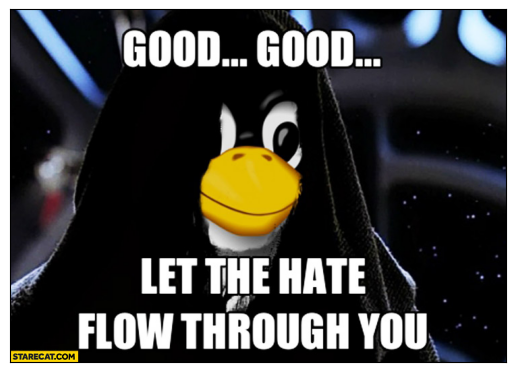

In [5]:
# Don't modify this code block!
# Make a random dataset with 10 samples of 3 features each
X = Data(randn(10,3))
Y = randn(10,2)            # The label vector has to entries per sample
L1 = Linear(X,num_out_features=4)  # A linear layer maps each 3-vector onto a 2-vector
L2 = Linear(L1,num_out_features=2)  # A linear layer maps each 3-vector onto a 2-vector
loss = SquareLoss(L2,Y)    # Loss compares the output of the linear layer to the labels
# Check the gradient for W
def network_loss(W): # Computes the value of the loss function
    L2.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L2_grad(W):      # Gradient of loss function with respect to weights in linear layer
    L2.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L2.G
W = normal(size=L2.W.shape)
did_pass = check_gradient(network_loss,L2_grad,W)
assert did_pass, "Your linear layer is no good!  You did not get the right gradient with respect to W."

# Check that the correct gradient is passed back
def network_loss(W): # Computes the value of the loss function
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):      # Gradient of loss function with respect to weights in linear layer
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your linear layer is no good!  You did not pass back the correct gradient with respect to the layer inputs."

print("TEST PASSED!  Your linear layer is terrific")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/penguin_hate.png")

# Problem 2 - Relu non-linearity

Neural nets are no good without non-linearities.  If all the layers are linear operators, then the entire network can never be any more powerful than a single linear operator (why?).  Implement a Relu non-linearity.

In [6]:
class Relu:
    """Given an input matrix X, with one feature vector per row,
    this layer computes maximum(X,0), where the maximum operator is coordinate-wise."""
    def __init__(self, in_layer):
        self.in_layer = in_layer
        self.in_dims = in_layer.out_dims
        self.out_dims = self.in_dims
    def forward(self):
        self.in_array = self.in_layer.forward()
        self.out_array = np.maximum(self.in_array, 0)
        return self.out_array
    def backward(self, dwnstrm):
        relu_grad = (self.in_array > 0).astype(self.in_array.dtype)
        self.in_layer.backward(dwnstrm * relu_grad)

### Now test your Relu

Min relative error = 1.9584e-07
Test passed
TEST PASSED!  Your Relu layer works


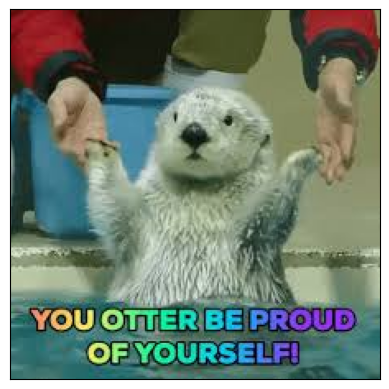

In [7]:
# Don't modify this code block!
# Create a dataset
X = Data(randn(10,3))
Y = randn(10,1)
# Create network with 2 linear layers and a Relu in the middle
L1 = Linear(X,5)
R1 = Relu(L1)
L2 = Linear(R1,1)
loss = SquareLoss(L2,Y)
# Methods to compute loss function, and gradient of loss with respect to L1 parameters.  This gradient has to
# backprop through your Relu, so this test should fail if your Relu is messed up.
def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your gradient checker is no good!"
print("TEST PASSED!  Your Relu layer works")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/good_job_otter.jpeg")

# Problem 3 - cross entropy
A real classification net uses a cross-entropy loss instead of a least-squares loss. Given an input/logit vector $x$ with class label $k,$ the cross entropy is given by
  $$- \log\left(  \frac{\exp(x_k)} { \sum_i \exp(x_i) }   \right) = -x_k + \log( \sum_i \exp(x_i)).$$
You can use the `LeastSquares` loss class as a model for how to do this.  The formulas for forward and backward will be different though.

**Your implementation of this layer can never exponentiate a positive number!**


In [8]:
class CrossEntropy:
    """Given a matrix of logits (one logit vector per row), and a vector labels,
    compute the cross entropy of the softmax.
    The labels must be a 1d vector"""
    def __init__(self, in_layer, ones_hot):
        self.in_layer = in_layer
        self.ones_hot = ones_hot
    def set_labels(self, ones_hot):
        self.ones_hot = ones_hot
    def forward(self):
        self.logits = self.in_layer.forward()
        N, K = self.logits.shape
        max_row = np.max(self.logits, axis=1, keepdims=True)
        exps = np.exp(self.logits - max_row)
        sum_exps = np.sum(exps, axis=1, keepdims=True)
        self.softmax = exps / sum_exps

        log_sum_exps = np.log(sum_exps) + max_row
        self.log_softmax = self.logits - log_sum_exps

        cross_entropy = - np.sum(self.ones_hot * self.log_softmax) / N

        return cross_entropy

    def backward(self):
        N = self.logits.shape[0]
        grad_logits = (self.softmax - self.ones_hot) / N
        self.in_layer.backward(grad_logits)

### Now, run this unit test for your cross-entropy layer

Checking the gradient...
Min relative error = 2.5092e-07
Test passed
    Passed
Checking that your method is stable with large inputs.
    Passed
TEST PASSED!  Your softmax layer isn't good...it's teeeerific!


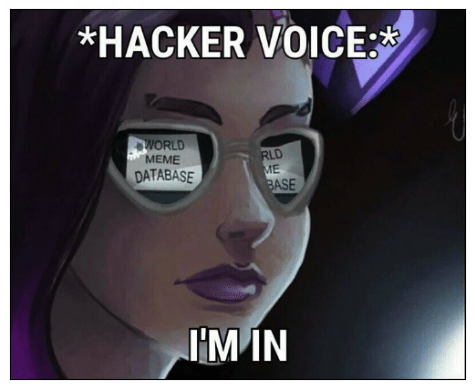

In [9]:
# Don't modify this code block!
## Make dataset
X = Data(randn(10,3))    # Create 10 random feature vectors of length 3
Y = randint(5,size=(10)) # Assign a random class to each vector
Y = np.eye(5)[Y]         # Convert the 1D label vector to a 2D one's hot encoding with a 5-entry row for each sample
# Build neural net with a linear layer, Relu, and a cross entropy loss
L1 = Linear(X,5)
R1 = Relu(L1)
loss = CrossEntropy(R1,Y)
# Build methods to get loss and gradient
def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
print('Checking the gradient...')
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your softmax gradient is no good! Check your gradient formula!"
print('    Passed')
print('Checking that your method is stable with large inputs.')
L1.W = normal(size=L1.W.shape)*1000
l = loss.forward()
assert np.isfinite(l), "Your softmax gradient is unstable.  You probably exponentiated positive numbers.  That's not allowed!"
print('    Passed')
print("TEST PASSED!  Your softmax layer isn't good...it's teeeerific!")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/hacker_database.png")

# Problem 4 - bias
Right now each neuron computes a linear operator on the inputs (i.e., $xw$ for some input row vector $x$ and weight vector $w$).  In practice, we want to compute $xw+b$ for some constant b.  

Write a layer that takes in a feature map, and adds a (trainable) constant to each output.

In [10]:
class Bias:
    """Given an input matrix X, add a trainable constant to each entry."""
    def __init__(self, in_layer):
        self.in_layer = in_layer
        num_data, num_in_features = in_layer.out_dims
        self.out_dims = in_layer.out_dims
        # Declare the weight matrix
        self.W = randn(1,num_in_features)
    def forward(self):
        self.in_array = self.in_layer.forward()
        self.out_array = self.in_array + self.W
        return self.out_array

    def backward(self, dwnstrm):
        # Compute the gradient of the loss with respect to W, and store it as G
        self.G = dwnstrm.sum(axis=0, keepdims=True)
        input_grad = dwnstrm
        # Compute grad of loss with respect to inputs, and hand this gradient backward to the layer behind
        self.in_layer.backward(input_grad)

### Your code is always perfect.  But there's all sorts of bugs in the Friendster codebase.  So better run this unit test to be sure...

Min relative error = 1.0963e-07
Test passed
Min relative error = 8.7262e-08
Test passed
TEST PASSED!  Your bias layer works


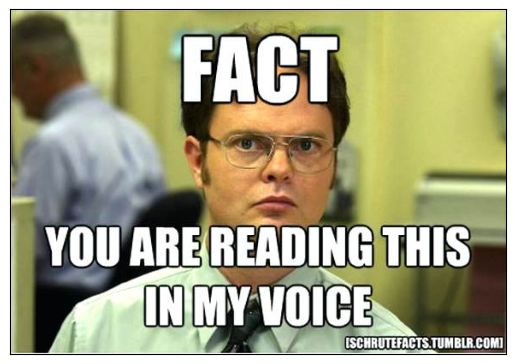

In [11]:
# Don't modify this code block!
# Create a dataset
X = Data(randn(10,3))
Y = randn(10,1)
# Create network with 2 linear layers and a Relu in the middle
L1 = Linear(X,5)
B1 = Bias(L1)
R1 = Relu(B1)
L2 = Linear(R1,1)
loss = SquareLoss(L2,Y)
# Build methods to get loss and gradient
def network_loss(W):
    B1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def B1_grad(W):
    B1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return B1.G
W = normal(size=B1.W.shape)
did_pass = check_gradient(network_loss,B1_grad,W)
assert did_pass, "Your bias gradient is no good.  You used the wrong formula for the gradient with respect to W!"
def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value
def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your bias gradient is no good!  You passed back the wrong gradient with respect to layer inputs!"
print("TEST PASSED!  Your bias layer works")
good_job("https://www.cs.umd.edu/~tomg/img/important_memes/my_voice.png")

# Finally, test a complete net with 3 linear layers, relus, bias, and cross-entropy

Min relative error = 3.9186e-09
Test passed
Wow!  You did it!  As your boss, I'm soooo impressed with you!  You're the best dev we're got here at
Friendster, and you've been promoted to CTO!  Stock value is up and we've got 14M new users!


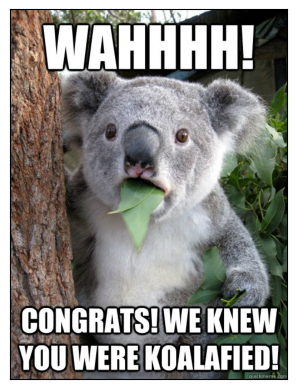

In [12]:
# Don't modify this code block!
## Make dataset
X = Data(randn(10,3))    # Create 10 random feature vectors of length 3
Y = randint(5,size=(10)) # Assign a random class to each vector
Y = np.eye(5)[Y]         # Convert the 1D label vector to a 2D one's hot encoding with a 5-entry row for each sample

# Create network with 3 linear layers, biases, and Relu
L1 = Linear(X,5)
B1 = Bias(L1)
R1 = Relu(B1)
L2 = Linear(R1,8)
B2 = Bias(L2)
R2 = Relu(B2)
L3 = Linear(R2,5)
B3 = Bias(L3)
loss = CrossEntropy(B3,Y)

def network_loss(W):
    L1.W[:] = W[:]
    loss_value = loss.forward()
    return loss_value

def L1_grad(W):
    L1.W[:] = W[:]
    loss.forward()
    loss.backward()
    return L1.G
W = normal(size=L1.W.shape)
did_pass = check_gradient(network_loss,L1_grad,W)
assert did_pass, "Your network failed!  Run all the unit tests above and double check!"
print("""Wow!  You did it!  As your boss, I'm soooo impressed with you!  You're the best dev we're got here at
Friendster, and you've been promoted to CTO!  Stock value is up and we've got 14M new users!""")

good_job("https://www.cs.umd.edu/~tomg/img/important_memes/koala.png")


# Part 2: Convolutional neural networks

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [14]:
def compute_mean_std():
  temp_transform = transforms.ToTensor()
  temp_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=temp_transform)
  temp_loader = DataLoader(temp_trainset, batch_size=len(temp_trainset), shuffle=False)
  data_iter = iter(temp_loader)
  images,_ = next(data_iter)
  mean = images.mean(dim=[0, 2, 3])
  std = images.std(dim=[0, 2, 3])
  return mean, std

In [15]:
def build_transforms(mean, std, augmentation=False):
  if augmentation:
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
  else:
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

  test_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean, std),
  ])
  return train_transform, test_transform

In [16]:
def visualize_classes(dataset, classes):
  fig, axes = plt.subplots(2, 5, figsize=(12, 6))
  shown_classes = set()
  idx = 0
  for img, label in dataset:
    if label not in shown_classes:
      ax = axes[idx // 5, idx % 5]
      img_np = img.numpy().transpose((1, 2, 0))
      ax.imshow(img_np)
      ax.set_title(classes[label])
      ax.axis('off')
      shown_classes.add(label)
      idx += 1
    if len(shown_classes) == 10:
      break
  plt.tight_layout()
  plt.show()

1. CNN (3 convolutional layers)

In [17]:
class SimpleCNN(nn.Module):
  def __init__(self, initial_filters=16, num_classes=10):
    super(SimpleCNN, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, initial_filters, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(initial_filters, initial_filters*2, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(initial_filters*2, initial_filters*4, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((1, 1))
    )
    self.classifier = nn.Linear(initial_filters*4, num_classes) # nn.Linear(in_features, out_features)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

2. ResNet32 Model

In [18]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [19]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        self.linear = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_block, stride):
        strides = [stride] + [1]*(num_block-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [20]:
def ResNet32(num_classes=10):
    return ResNet(BasicBlock, [5, 5, 5], num_classes=num_classes)

3. Train and evaluate functions

In [21]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

4. Training
*   Without augmentation
*   With augmentation



Using device: cuda


100%|████████████████████████████████████████████████████████| 170498071/170498071 [00:02<00:00, 56902101.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Train dataset mean: tensor([0.4914, 0.4822, 0.4465])
Train dataset std: tensor([0.2470, 0.2435, 0.2616])
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Visualizing 10 sample images (no augmentation):


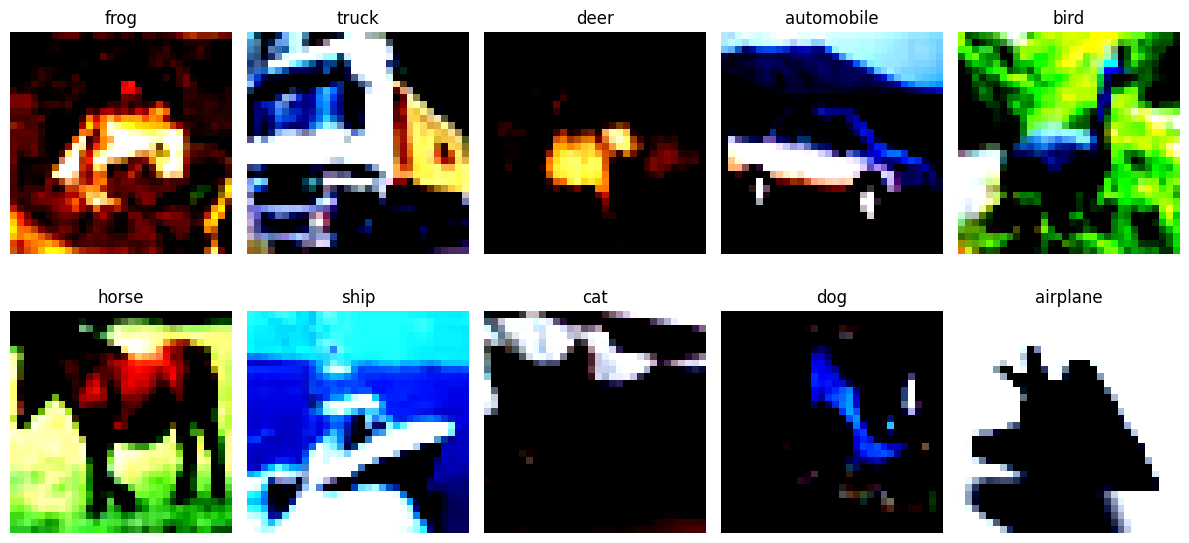

Training SimpleCNN (16 filters) without augmentation ...
Epoch [10/100] | Train Loss: 0.8856, Acc: 0.6905 | Test Loss: 0.9706, Acc: 0.6570
Epoch [20/100] | Train Loss: 0.7461, Acc: 0.7432 | Test Loss: 0.8355, Acc: 0.7146
Epoch [30/100] | Train Loss: 0.6977, Acc: 0.7579 | Test Loss: 0.7604, Acc: 0.7416
Epoch [40/100] | Train Loss: 0.6372, Acc: 0.7775 | Test Loss: 0.7494, Acc: 0.7463
Epoch [50/100] | Train Loss: 0.5769, Acc: 0.8008 | Test Loss: 0.6982, Acc: 0.7592
Epoch [60/100] | Train Loss: 0.5188, Acc: 0.8210 | Test Loss: 0.6615, Acc: 0.7764
Epoch [70/100] | Train Loss: 0.4530, Acc: 0.8447 | Test Loss: 0.6333, Acc: 0.7833
Epoch [80/100] | Train Loss: 0.3974, Acc: 0.8659 | Test Loss: 0.6290, Acc: 0.7873
Epoch [90/100] | Train Loss: 0.3489, Acc: 0.8857 | Test Loss: 0.5993, Acc: 0.8028
Epoch [100/100] | Train Loss: 0.3293, Acc: 0.8954 | Test Loss: 0.5941, Acc: 0.8015
Training SimpleCNN (64 filters) without augmentation ...
Epoch [10/100] | Train Loss: 0.6058, Acc: 0.7895 | Test Loss: 0.6

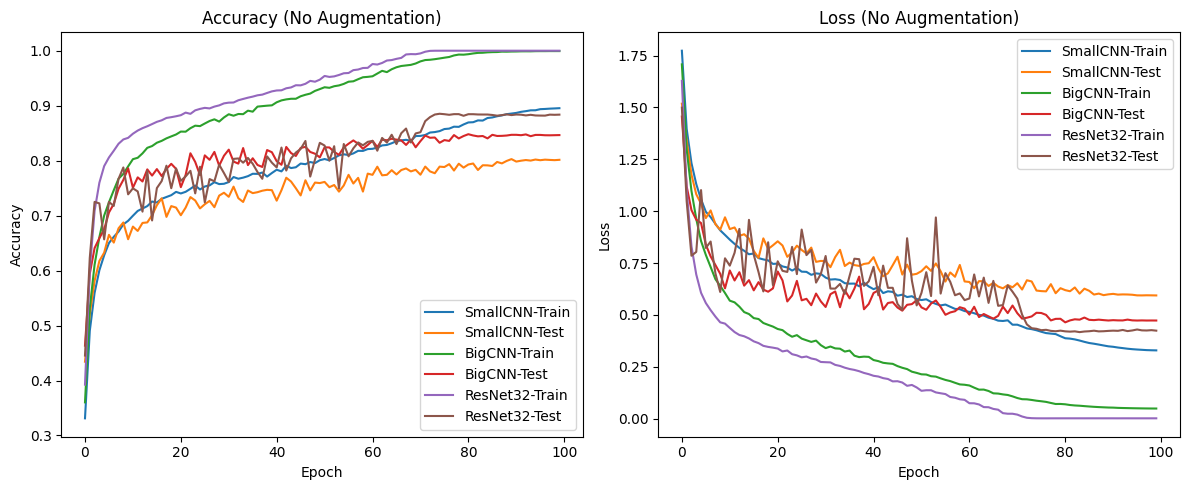

Now training again with data augmentation ...
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Visualizing 10 sample images (with augmentation):


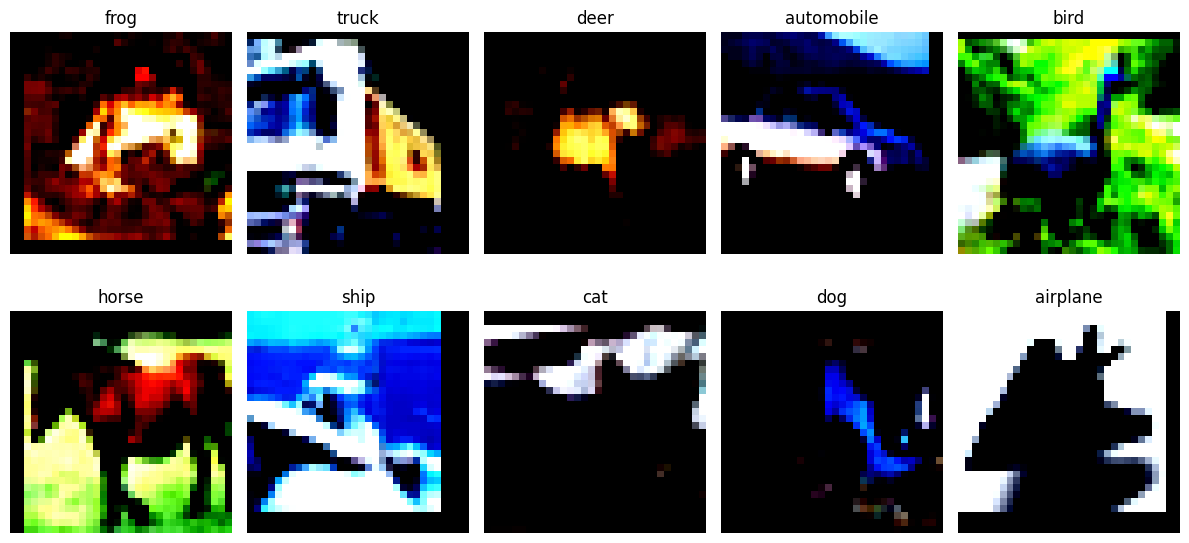

Training SmallCNN (16 filters) with augmentation ...
[Aug] Epoch [10/100] | SmallCNN Train Loss: 0.9833, Acc: 0.6581 | Test Loss: 1.0745, Acc: 0.6275
[Aug] Epoch [20/100] | SmallCNN Train Loss: 0.8719, Acc: 0.6992 | Test Loss: 0.8196, Acc: 0.7185
[Aug] Epoch [30/100] | SmallCNN Train Loss: 0.8053, Acc: 0.7238 | Test Loss: 0.8071, Acc: 0.7147
[Aug] Epoch [40/100] | SmallCNN Train Loss: 0.7586, Acc: 0.7391 | Test Loss: 0.8098, Acc: 0.7225
[Aug] Epoch [50/100] | SmallCNN Train Loss: 0.7274, Acc: 0.7498 | Test Loss: 0.7713, Acc: 0.7341
[Aug] Epoch [60/100] | SmallCNN Train Loss: 0.6807, Acc: 0.7656 | Test Loss: 0.6863, Acc: 0.7624
[Aug] Epoch [70/100] | SmallCNN Train Loss: 0.6307, Acc: 0.7861 | Test Loss: 0.6487, Acc: 0.7790
[Aug] Epoch [80/100] | SmallCNN Train Loss: 0.5884, Acc: 0.7978 | Test Loss: 0.6342, Acc: 0.7848
[Aug] Epoch [90/100] | SmallCNN Train Loss: 0.5492, Acc: 0.8131 | Test Loss: 0.5976, Acc: 0.7976
[Aug] Epoch [100/100] | SmallCNN Train Loss: 0.5319, Acc: 0.8191 | Test Lo

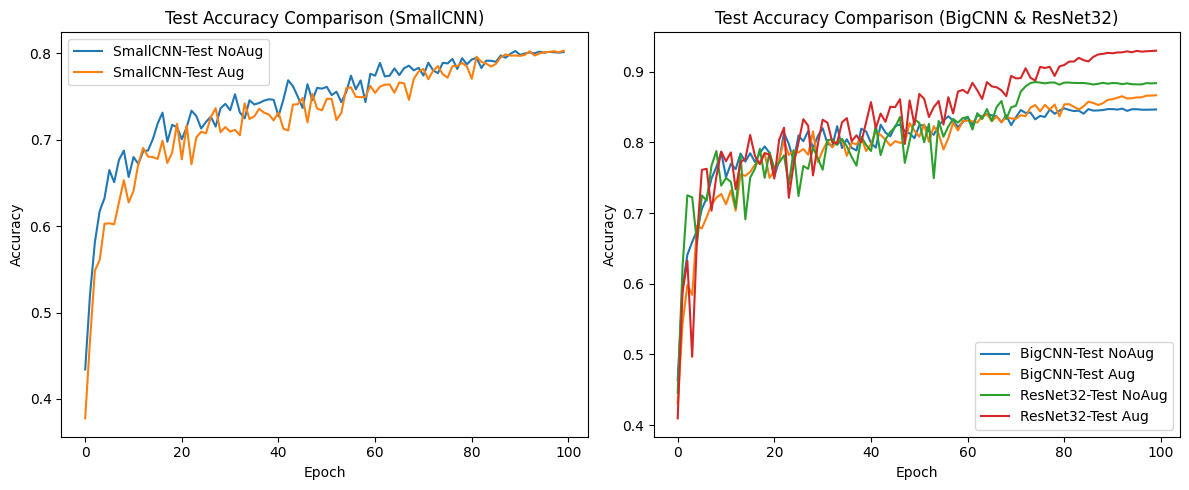

In [22]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    mean, std = compute_mean_std()
    print("Train dataset mean:", mean)
    print("Train dataset std:", std)

    train_transform, test_transform = build_transforms(mean, std, augmentation=False)

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )

    classes = train_dataset.classes
    print("Visualizing 10 sample images (no augmentation):")
    visualize_classes(train_dataset, classes)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

    num_epochs = 100
    criterion = nn.CrossEntropyLoss()

    print("Training SimpleCNN (16 filters) without augmentation ...")
    model_small = SimpleCNN(initial_filters=16).to(device)
    optimizer_small = optim.SGD(model_small.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler_small = optim.lr_scheduler.CosineAnnealingLR(optimizer_small, T_max=num_epochs)

    train_loss_small, test_loss_small = [], []
    train_acc_small, test_acc_small = [], []

    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model_small, train_loader, criterion, optimizer_small, device)
        te_loss, te_acc = evaluate(model_small, test_loader, criterion, device)

        scheduler_small.step()

        train_loss_small.append(tr_loss)
        train_acc_small.append(tr_acc)
        test_loss_small.append(te_loss)
        test_acc_small.append(te_acc)

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | Test Loss: {te_loss:.4f}, Acc: {te_acc:.4f}")

    print("Training SimpleCNN (64 filters) without augmentation ...")
    model_big = SimpleCNN(initial_filters=64).to(device)
    optimizer_big = optim.SGD(model_big.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler_big = optim.lr_scheduler.CosineAnnealingLR(optimizer_big, T_max=num_epochs)

    train_loss_big, test_loss_big = [], []
    train_acc_big, test_acc_big = [], []

    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model_big, train_loader, criterion, optimizer_big, device)
        te_loss, te_acc = evaluate(model_big, test_loader, criterion, device)

        scheduler_big.step()

        train_loss_big.append(tr_loss)
        train_acc_big.append(tr_acc)
        test_loss_big.append(te_loss)
        test_acc_big.append(te_acc)

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | Test Loss: {te_loss:.4f}, Acc: {te_acc:.4f}")

    print("Training ResNet32 without augmentation ...")
    model_resnet = ResNet32(num_classes=10).to(device)
    optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler_resnet = optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=num_epochs)

    train_loss_res, test_loss_res = [], []
    train_acc_res, test_acc_res = [], []

    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model_resnet, train_loader, criterion, optimizer_resnet, device)
        te_loss, te_acc = evaluate(model_resnet, test_loader, criterion, device)

        scheduler_resnet.step()

        train_loss_res.append(tr_loss)
        train_acc_res.append(tr_acc)
        test_loss_res.append(te_loss)
        test_acc_res.append(te_acc)

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | Test Loss: {te_loss:.4f}, Acc: {te_acc:.4f}")

    epochs = range(num_epochs)
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc_small, label='SmallCNN-Train')
    plt.plot(epochs, test_acc_small, label='SmallCNN-Test')
    plt.plot(epochs, train_acc_big, label='BigCNN-Train')
    plt.plot(epochs, test_acc_big, label='BigCNN-Test')
    plt.plot(epochs, train_acc_res, label='ResNet32-Train')
    plt.plot(epochs, test_acc_res, label='ResNet32-Test')
    plt.title('Accuracy (No Augmentation)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss_small, label='SmallCNN-Train')
    plt.plot(epochs, test_loss_small, label='SmallCNN-Test')
    plt.plot(epochs, train_loss_big, label='BigCNN-Train')
    plt.plot(epochs, test_loss_big, label='BigCNN-Test')
    plt.plot(epochs, train_loss_res, label='ResNet32-Train')
    plt.plot(epochs, test_loss_res, label='ResNet32-Test')
    plt.title('Loss (No Augmentation)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Now training again with data augmentation ...")
    aug_train_transform, aug_test_transform = build_transforms(mean, std, augmentation=True)

    aug_train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=aug_train_transform
    )
    aug_test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=aug_test_transform
    )

    print("Visualizing 10 sample images (with augmentation):")
    visualize_classes(aug_train_dataset, classes)

    aug_train_loader = DataLoader(aug_train_dataset, batch_size=128, shuffle=True, num_workers=2)
    aug_test_loader = DataLoader(aug_test_dataset, batch_size=128, shuffle=False, num_workers=2)

    print("Training SmallCNN (16 filters) with augmentation ...")
    model_small_aug = SimpleCNN(initial_filters=16).to(device)
    optimizer_small_aug = optim.SGD(model_small_aug.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler_small_aug = optim.lr_scheduler.CosineAnnealingLR(optimizer_small_aug, T_max=num_epochs)

    train_loss_small_aug, test_loss_small_aug = [], []
    train_acc_small_aug, test_acc_small_aug = [], []

    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model_small_aug, aug_train_loader, criterion, optimizer_small_aug, device)
        te_loss, te_acc = evaluate(model_small_aug, aug_test_loader, criterion, device)

        scheduler_small_aug.step()

        train_loss_small_aug.append(tr_loss)
        train_acc_small_aug.append(tr_acc)
        test_loss_small_aug.append(te_loss)
        test_acc_small_aug.append(te_acc)

        if (epoch+1) % 10 == 0:
            print(f"[Aug] Epoch [{epoch+1}/{num_epochs}] | SmallCNN Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | Test Loss: {te_loss:.4f}, Acc: {te_acc:.4f}")

    print("Training BigCNN (64 filters) with augmentation ...")
    model_big_aug = SimpleCNN(initial_filters=64).to(device)
    optimizer_big_aug = optim.SGD(model_big_aug.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler_big_aug = optim.lr_scheduler.CosineAnnealingLR(optimizer_big_aug, T_max=num_epochs)

    train_loss_big_aug, test_loss_big_aug = [], []
    train_acc_big_aug, test_acc_big_aug = [], []

    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model_big_aug, aug_train_loader, criterion, optimizer_big_aug, device)
        te_loss, te_acc = evaluate(model_big_aug, aug_test_loader, criterion, device)

        scheduler_big_aug.step()

        train_loss_big_aug.append(tr_loss)
        train_acc_big_aug.append(tr_acc)
        test_loss_big_aug.append(te_loss)
        test_acc_big_aug.append(te_acc)

        if (epoch+1) % 10 == 0:
            print(f"[Aug] Epoch [{epoch+1}/{num_epochs}] | BigCNN Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | Test Loss: {te_loss:.4f}, Acc: {te_acc:.4f}")

    print("Training ResNet32 with augmentation ...")
    model_resnet_aug = ResNet32(num_classes=10).to(device)
    optimizer_resnet_aug = optim.SGD(model_resnet_aug.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler_resnet_aug = optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet_aug, T_max=num_epochs)

    train_loss_res_aug, test_loss_res_aug = [], []
    train_acc_res_aug, test_acc_res_aug = [], []

    for epoch in range(num_epochs):
        tr_loss, tr_acc = train_one_epoch(model_resnet_aug, aug_train_loader, criterion, optimizer_resnet_aug, device)
        te_loss, te_acc = evaluate(model_resnet_aug, aug_test_loader, criterion, device)

        scheduler_resnet_aug.step()

        train_loss_res_aug.append(tr_loss)
        train_acc_res_aug.append(tr_acc)
        test_loss_res_aug.append(te_loss)
        test_acc_res_aug.append(te_acc)

        if (epoch+1) % 10 == 0:
            print(f"[Aug] Epoch [{epoch+1}/{num_epochs}] | ResNet32 Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | Test Loss: {te_loss:.4f}, Acc: {te_acc:.4f}")

    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, test_acc_small, label='SmallCNN-Test NoAug')
    plt.plot(epochs, test_acc_small_aug, label='SmallCNN-Test Aug')
    plt.title('Test Accuracy Comparison (SmallCNN)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, test_acc_big, label='BigCNN-Test NoAug')
    plt.plot(epochs, test_acc_big_aug, label='BigCNN-Test Aug')
    plt.plot(epochs, test_acc_res, label='ResNet32-Test NoAug')
    plt.plot(epochs, test_acc_res_aug, label='ResNet32-Test Aug')
    plt.title('Test Accuracy Comparison (BigCNN & ResNet32)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()